In [1]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as LSCm
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
from scipy import integrate
from NesrHydrusAnalyst import *

In [2]:
src = '../Datasets/H3D2_SandDitch0011'

# Working with velocity

In [3]:
df = read_hydrus_data(folder=src, save_to_csv=False, read_velocities=True)
df.sample(3)

,n,x,y,z,Th_T0,Th_T5,Th_T15,Th_T30,Th_T60,Th_T120,...,V3_T240,V1_T500,V2_T500,V3_T500,V1_T720,V2_T720,V3_T720,V1_T1440,V2_T1440,V3_T1440
2015,2015,43.1657,16.9231,21.74220,0.1,0.430000,0.430000,0.430000,0.430000,0.248138,...,-0.000426,-0.000111,-2.667570e-06,-0.000148,-0.000022,-9.603200e-07,-0.000079,0.000005,2.038290e-07,-0.000015
5706,5706,20.4500,16.1220,17.17530,0.2,0.200117,0.203017,0.338310,0.385768,0.359408,...,-0.000306,-0.000055,-1.135230e-06,-0.000139,-0.000043,-4.161610e-07,-0.000088,-0.000025,4.561010e-08,-0.000030
3710,3710,11.5515,10.7500,4.69074,0.2,0.200000,0.199999,0.199998,0.206055,0.324349,...,0.001170,-0.000129,-1.143680e-07,0.000493,-0.000112,-4.339300e-07,0.000290,-0.000062,-3.314890e-07,0.000068


In [4]:
print(list(df))

['n', 'x', 'y', 'z', 'Th_T0', 'Th_T5', 'Th_T15', 'Th_T30', 'Th_T60', 'Th_T120', 'Th_T180', 'Th_T240', 'Th_T500', 'Th_T720', 'Th_T1440', 'H_T0', 'H_T5', 'H_T15', 'H_T30', 'H_T60', 'H_T120', 'H_T180', 'H_T240', 'H_T500', 'H_T720', 'H_T1440', 'V1_T0', 'V2_T0', 'V3_T0', 'V1_T5', 'V2_T5', 'V3_T5', 'V1_T15', 'V2_T15', 'V3_T15', 'V1_T30', 'V2_T30', 'V3_T30', 'V1_T60', 'V2_T60', 'V3_T60', 'V1_T120', 'V2_T120', 'V3_T120', 'V1_T180', 'V2_T180', 'V3_T180', 'V1_T240', 'V2_T240', 'V3_T240', 'V1_T500', 'V2_T500', 'V3_T500', 'V1_T720', 'V2_T720', 'V3_T720', 'V1_T1440', 'V2_T1440', 'V3_T1440']


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
n,8250.0,4.125500e+03,2381.714194,1.000000,2.063250e+03,4.125500e+03,6.187750e+03,8250.000000
x,8250.0,2.451462e+01,14.887410,-0.839105,1.155150e+01,2.439230e+01,3.752950e+01,49.960100
y,8250.0,9.983508e+00,6.314130,0.000000,4.615380e+00,9.991985e+00,1.538460e+01,20.000000
z,8250.0,1.186658e+01,6.483165,0.000000,6.190740e+00,1.178960e+01,1.778960e+01,22.981100
Th_T0,8250.0,1.778485e-01,0.034929,0.100000,1.500000e-01,2.000000e-01,2.000000e-01,0.200000
Th_T5,8250.0,1.886862e-01,0.066437,0.049132,1.999210e-01,2.000000e-01,2.000050e-01,0.430000
Th_T15,8250.0,2.104914e-01,0.086384,0.049792,2.000000e-01,2.000000e-01,2.063693e-01,0.430000
Th_T30,8250.0,2.355983e-01,0.097230,0.049960,2.000000e-01,2.000250e-01,2.886743e-01,0.430000
Th_T60,8250.0,2.954227e-01,0.100979,0.049914,2.000060e-01,2.919705e-01,3.900000e-01,0.430000
Th_T120,8250.0,2.915740e-01,0.075816,0.133659,2.084185e-01,3.117305e-01,3.615485e-01,0.426730


## The velocity components:
![From HYDRUS simulation](../Assets/H_velocity.png)
**V1 is the _x_ complonent of the velocity.**<br>
**V2 is the _y_ complonent of the velocity.**<br>
**V3 is the _z_ complonent of the velocity.**<br>


In [6]:
vr = 0
# v_mask = {0: 'Th', 1: 'H', 2.1:'V1', 2.2:'V2', 2.3:'V3'}[variable]
X, Z, M, x_vals, z_vals = get_grid_values(df, variable=vr)

X, Z, M, x_vals, z_vals

(array([[0.000, 0.500, 1.000, ..., 19.000, 19.500, 20.000],
        [0.000, 0.500, 1.000, ..., 19.000, 19.500, 20.000],
        [0.000, 0.500, 1.000, ..., 19.000, 19.500, 20.000],
        ...,
        [0.000, 0.500, 1.000, ..., 19.000, 19.500, 20.000],
        [0.000, 0.500, 1.000, ..., 19.000, 19.500, 20.000],
        [0.000, 0.500, 1.000, ..., 19.000, 19.500, 20.000]]),
 array([[0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
        [0.511, 0.511, 0.511, ..., 0.511, 0.511, 0.511],
        [1.021, 1.021, 1.021, ..., 1.021, 1.021, 1.021],
        ...,
        [21.960, 21.960, 21.960, ..., 21.960, 21.960, 21.960],
        [22.470, 22.470, 22.470, ..., 22.470, 22.470, 22.470],
        [22.981, 22.981, 22.981, ..., 22.981, 22.981, 22.981]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [0.184, 0.184, 0.184, ..., 0.184, 0.184, 0.184],
        [nan, nan, nan, ..., nan, nan, nan],


In [7]:
get_available_timesteps(df)

[0, 5, 15, 30, 60, 120, 180, 240, 500, 720, 1440]

In [8]:
get_full_dimensions(df)

{'x': (-0.839105, 49.9601), 'y': (0.0, 20.0), 'z': (0.0, 22.9811)}

In [9]:
M.min(), M.max()

(nan, nan)

In [10]:
np.nanmin(M), np.nanmax(M)

(0.1837599697958303, 0.3707341546192539)

In [11]:
get_legend_range(np.nanmin(M), np.nanmax(M))

array([0.200, 0.210, 0.220, 0.230, 0.240, 0.250, 0.260, 0.270, 0.280,
       0.290, 0.300, 0.310, 0.320, 0.330, 0.340, 0.350, 0.360, 0.370])

In [12]:
get_legend_range_max(M)

array([0.200, 0.210, 0.220, 0.230, 0.240, 0.250, 0.260, 0.270, 0.280,
       0.290, 0.300, 0.310, 0.320, 0.330, 0.340, 0.350, 0.360, 0.370])

In [31]:
vr = 0
v_mask = {0: 'Th', 1: 'H', 2.1: 'V1', 2.2: 'V2', 2.3: 'V3'}[vr]
X, Z, M, x_vals, z_vals = get_grid_values(df, variable=vr)
print(
    f'for the variable {v_mask}:',
    '\nTime steps:', get_available_timesteps(df), '\nDimensions:',
    get_full_dimensions(df), '\nLegend range:',
    [float(f'{_:4.2f}') for _ in get_legend_range_max(M)],
    '\nx_vals{}, z_vals{}, X{}, Z{}, M{}'.format(x_vals.shape, z_vals.shape,
                                                 X.shape, Z.shape, M.shape))

for the variable Th: 
Time steps: [0, 5, 15, 30, 60, 120, 180, 240, 500, 720, 1440] 
Dimensions: {'x': (-0.839105, 49.9601), 'y': (0.0, 20.0), 'z': (0.0, 22.9811)} 
Legend range: [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37] 
x_vals(41,), z_vals(46,), X(46, 41), Z(46, 41), M(46, 41)


In [34]:
v_mask = {0: 'Th', 1: 'H', 2.1: 'V1', 2.2: 'V2', 2.3: 'V3'}
for vr in v_mask.keys():
    X, Z, M, x_vals, z_vals = get_grid_values(df, variable=vr)
    print(
        f'\nFor the variable {v_mask[vr]}:',
        '\nTime steps:', get_available_timesteps(df), '\nDimensions:',
        get_full_dimensions(df), '\nLegend range:',
        [float(f'{_:4.2f}') for _ in get_legend_range_max(M)],
        '\nx_vals{}, z_vals{}, X{}, Z{}, M{}'.format(x_vals.shape, z_vals.shape,
                                                     X.shape, Z.shape, M.shape))


For the variable Th: 
Time steps: [0, 5, 15, 30, 60, 120, 180, 240, 500, 720, 1440] 
Dimensions: {'x': (-0.839105, 49.9601), 'y': (0.0, 20.0), 'z': (0.0, 22.9811)} 
Legend range: [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37] 
x_vals(41,), z_vals(46,), X(46, 41), Z(46, 41), M(46, 41)

For the variable H: 
Time steps: [0, 5, 15, 30, 60, 120, 180, 240, 500, 720, 1440] 
Dimensions: {'x': (-0.839105, 49.9601), 'y': (0.0, 20.0), 'z': (0.0, 22.9811)} 
Legend range: [-120.0, -110.0, -100.0, -90.0, -80.0, -70.0, -60.0, -50.0, -40.0, -30.0, -20.0, -10.0] 
x_vals(41,), z_vals(46,), X(46, 41), Z(46, 41), M(46, 41)

For the variable V1: 
Time steps: [0, 5, 15, 30, 60, 120, 180, 240, 500, 720, 1440] 
Dimensions: {'x': (-0.839105, 49.9601), 'y': (0.0, 20.0), 'z': (0.0, 22.9811)} 
Legend range: [-0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02] 
x_vals(41,), z_vals(46,), X(46, 41), Z(46, 41), M(46, 41)

For the variable V2: 
Ti

# Drawing velocity and moisture sections

In [38]:
def draw_full_contour(data_frame,variable=0, time_step=180, grid= 0.5, 
                      crosses=35., tol=10., section= 'x', levels=None,
                      plot_title="ElNesr cross sectional contour map",
                      return_arrays=True, x_step=None, z_step=None,
                      mirror_x=False, mirror_z=False, is2d=False, 
                      output_the_contour=True, is_axisymmetric=False,
                      return_figure_object=False, fig_size=(18, 7)):
    
    '''
    Either (1) set the return_arrays to True and use on right 
                hand side of equal sign, 
    OR     (2) set the return_arrays to False and use the function as is.
    Examples:
    (1)
       arrays = draw_full_contour(data_frame,variable, time_step, grid, 
                                   crosses, tol, section)
       It will draws the chart AND sets arrays=X, Z, M, levels
    (2)
       draw_full_contour(data_frame,variable, time_step, grid, crosses, 
                           tol, section, return_arrays=False)    
    '''
#     print('is2d=', is2d)
    X, Z, M, x_vals, z_vals = get_grid_values(data_frame, variable, 
                                              time_step, grid, crosses, 
                                              tol, section, is2d=is2d)
    # print(x_vals.shape, z_vals.shape, X.shape, Z.shape, M.shape)
    if levels is None:
        levels = get_legend_range(np.nanmin(M),np.nanmax(M))#np.arange(0.15, 0.42, 0.03)

    mn, mx = np.nanmin(M),np.nanmax(M)
    # print (mx,mn, mx-mn)
    if mx - mn < 0.000000001:
        print('For the requested contour map of {}'.format(plot_title), end='. ')
        print ("The map has one value only ({}), no contour map will be drawn.".
               format(mn))
        can_draw_figure=False
    else:
        can_draw_figure=True

    if not output_the_contour and not return_figure_object:
        fig = None
    else:
        if can_draw_figure:
            fig = draw_contour(X, Z, M, levels, plot_title, x_step, z_step,
                             mirror_x, mirror_z, return_figure_object, fig_size=fig_size);
        else:
            fig = None

#     exit()
    if return_arrays:
        if output_the_contour:
            if return_figure_object:
                return X, Z, M, levels, fig
            else: # return_figure_object=False
                display(fig)
                # fig.show()
                return X, Z, M, levels
        else:  #output_the_contour=False
            if return_figure_object:
                return X, Z, M, levels, fig
            else: # return_figure_object=False
                return X, Z, M, levels
    else:  #return_arrays=False
        if output_the_contour:
            if return_figure_object:
                return fig
            else: # return_figure_object=False
                display(fig)
                # fig.show()
        else:  #output_the_contour=False
            if return_figure_object:
                return fig
            
def draw_contour(X, Z, M, levels=None,
                 plot_title="ElNesr cross sectional contour map",
                 x_step=10., z_step=25., mirror_x=False, mirror_z=False,
                 return_figure_object=False, fig_size=(18, 7)):
    '''

    '''
#     print('mir_X draw_contour: ', mirror_x)
    fig = plt.figure(num=None, figsize=fig_size, dpi=80,
                     facecolor='w', edgecolor='k')
    origin = 'lower'

    if levels is None:
        #         print(M.min(), M.max())
        try:
            #             levels = get_legend_range(M.min(), M.max())#np.arange(0.15, 0.42, 0.03)
            # np.arange(0.15, 0.42, 0.03)
            levels = get_legend_range(np.nanmin(M), np.nanmax(M))
        except:
            levels = get_legend_range(-.15, 0.15)

#     CS_lines = plt.contour (X, Z, M, levels, cmap=plt.cm.Accent_r,
#                             linewidths=(2,), origin=origin, extend='both')
#     CS_lines = plt.contour (X, Z, M, levels, cmap=plt.cm.Accent_r,
#                             linewidths=(0.25,), origin=origin, extend='both')
    CS_lines = plt.contour(X, Z, M, levels, cmap=plt.cm.Accent_r,
                           linewidths=(0.9,), origin=origin, extend='both')

    CS_fill = plt.contourf(X, Z, M, levels, cmap=plt.cm.YlGn,
                           origin=origin, extend='both')

    CS_fill.cmap.set_under('oldlace')
    CS_fill.cmap.set_over('darkslategrey')
    plt.title(plot_title)
    plt.ylabel("Depth (cm)")
    cols = plt.cm.Accent_r(CS_lines.norm(CS_lines.levels))
    # plt.clabel(CS_lines, linewidths=4, fmt='%2.2f', fontsize='x-large',
    plt.clabel(CS_lines, fmt='%2.2f', fontsize='x-large',
               colors=cols, inline=True, inline_spacing=10)
    plt.colorbar(CS_fill)
#     print(Z.min(), Z.max(), X.min(), X.max())
#     print(plt.xlim)

    def adjust_max_and_min(_min, _max, _step):
        nn, xx, ss = _min, _max, _step
        if xx <= 0.:
            nn, xx = xx, nn
            if ss > 0:
                ss = -ss
        return nn, xx, ss

    def adjust_axis_labels(_min, _max, _step):
        nn, xx, ss = adjust_max_and_min(_min, _max, _step)

        x_list = np.arange(nn, xx, ss)
        if abs(x_list[-1]-xx) > 3:  # The last number is far enough from
                                 # the maximum element
            x_list = np.hstack([x_list, xx])
        else:  # The last number is too close to the maximum element
            x_list = np.hstack([x_list[:-1], xx])
        return x_list

    def adjust_mirrored_labels(_min, _max, _step):
        #         print(_min, _max, _step)
        nn, xx, ss = adjust_max_and_min(_min, _max, _step)
#         print(nn, xx, ss)
        x_mid = (xx-nn)/2.
#         print(x_mid)

        if x_mid < 0:
            right_list = adjust_axis_labels(min(x_mid, xx), max(x_mid, xx), ss)
#             print('Right list',right_list)
            left_list = right_list - x_mid
#             print('left List',left_list)
            right_list = x_mid - right_list
#             print('Right list2',right_list)

            left_list.sort()
#             print('left List2', left_list)

            label_list = np.hstack([left_list[:-1], right_list])
#             print('Label list',label_list)

            real_list = x_mid-label_list
#             print('Real list',real_list)
            label_list = label_list[::-1]
#             print('Label list3',label_list)
            return real_list, label_list
        elif x_mid > 0:
            right_list = adjust_axis_labels(x_mid, xx, ss)
#             print('Right list',right_list)
            left_list = 2 * x_mid - right_list
#             print(left_list)
            left_list.sort()
#             print(left_list)
            real_list = np.hstack([left_list[:-1], right_list])
#             print(real_list)
            label_list = real_list - x_mid
#             print(label_list)
            label_list = tuple(['{:3.1f}'.format(x) for x in label_list])
#             print(label_list)
            return real_list, label_list
        else:
            real_list, label_list = None, None
            return real_list, label_list


#     print('mir_X draw_contour2: ', mirror_x, 'x_step: ', x_step)
    if mirror_x:
        if x_step is not None:
            ticks, labels = adjust_mirrored_labels(X.min(), X.max(), x_step)
#             print(ticks, labels)
            plt.xticks(ticks, labels)
    else:  # No Mirroring
        if x_step is not None:
            plt.xticks(adjust_axis_labels(X.min(), X.max(), x_step))

    if mirror_z:
        if z_step is not None:
            ticks, labels = adjust_mirrored_labels(Z.min(), Z.max(), z_step)
            plt.yticks(ticks, labels)
    else:  # No Mirroring
        if z_step is not None:
            plt.yticks(adjust_axis_labels(Z.min(), Z.max(), z_step))
#     ax=plt.axes()
    ax = plt.gca()
    ax.grid(True, zorder=0)
#     plt.axes().xaxis.grid(True, zorder=0)
#     plt.axes().yaxis.grid(True, zorder=0)
    # plt.colorbar(CS_lines)
    if return_figure_object:
        return fig
    else:
        plt.show()
        
def get_fig_shape(data_frame, 
                  selected_dim='y',
                  max_height=8,
                  extra_width=1):
    '''
    Returns a proportunal tuple contains the width and the height for a specific data_frame
        If the data_frame is a 3D frame, then specify the slicing dimension as selected_dim, 
        with default value as 'y', which returns a xz 2D dataframe.
        the max_height is a limiting factor for the figure's shape, the width will vary, 
        but the height will be as specified hers, with default value =8.
        the width reflects the figure and the legend, that's why we add and extra_width of 1 
        in most cases, else if specified otherwise.
    '''
    dims = get_full_dimensions(data_frame)
    for dim, vals in dims.items():
        mn, mx = vals
        length = mx-mn
        dims[dim] = length
    sels = {d: dims[d] for d in dims.keys() if d != selected_dim}
    fig_shape = np.array(list(sels.values()))  # [::-1]
    fig_shape = np.ceil(fig_shape*max_height/fig_shape[1])
    fig_shape[0] += extra_width
    return tuple(fig_shape)

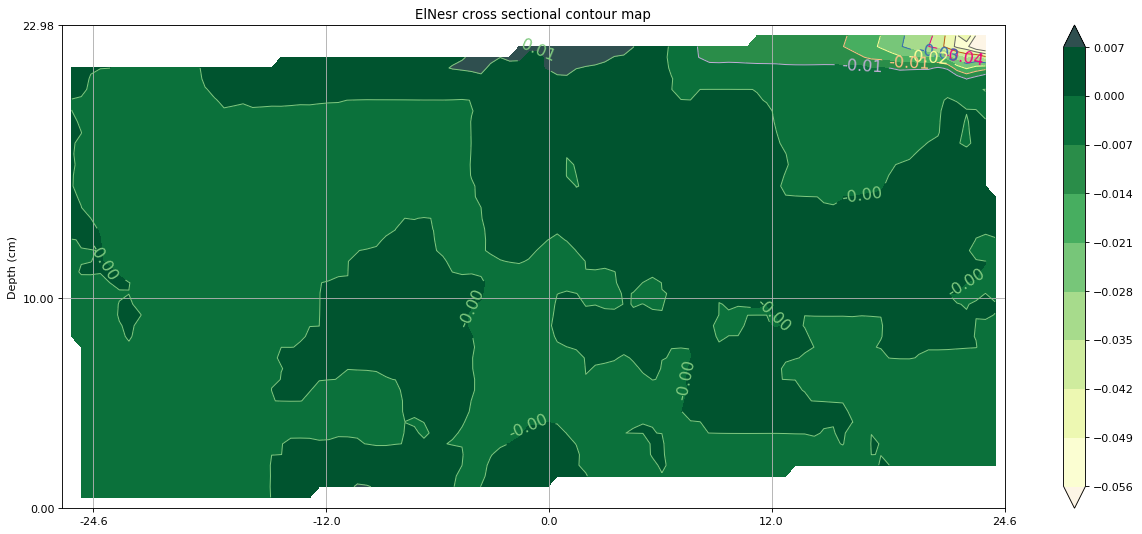

None

In [45]:
# testing draw_full_contour function
variable = 2.2  # {Velocity y component}
time_step = 60
grid = 0.5  # cm
crosses = 15.  #cm0)]
tol = 10.
section = 'y'

_ = draw_full_contour( df, variable, time_step, grid, crosses, tol, section, 
                      return_arrays=False, x_step=12, z_step=10, 
                      mirror_x=True, mirror_z=False, 
                      fig_size=get_fig_shape(df, section))

'Th'

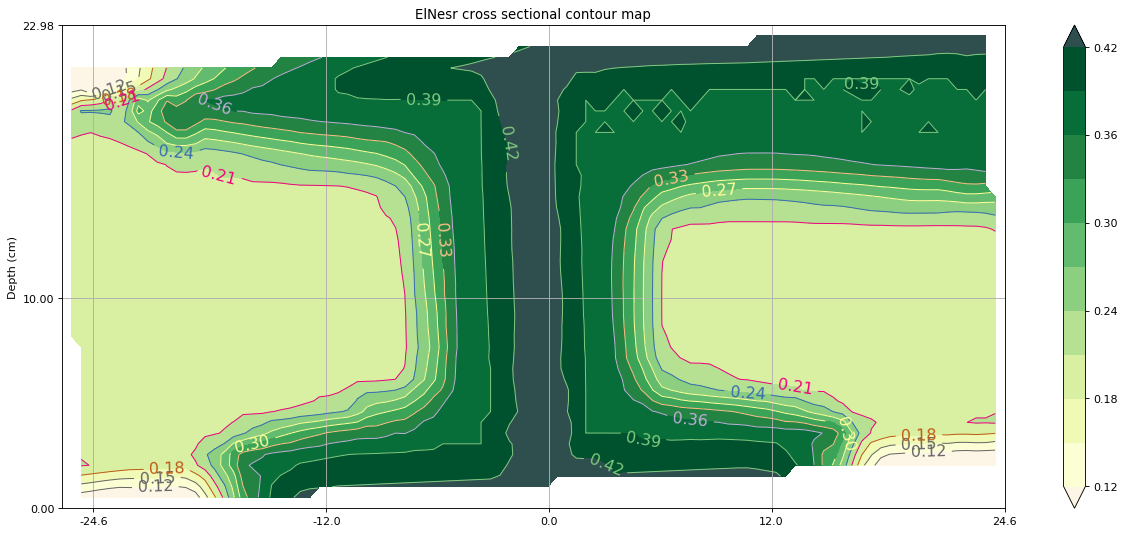

None

'H'

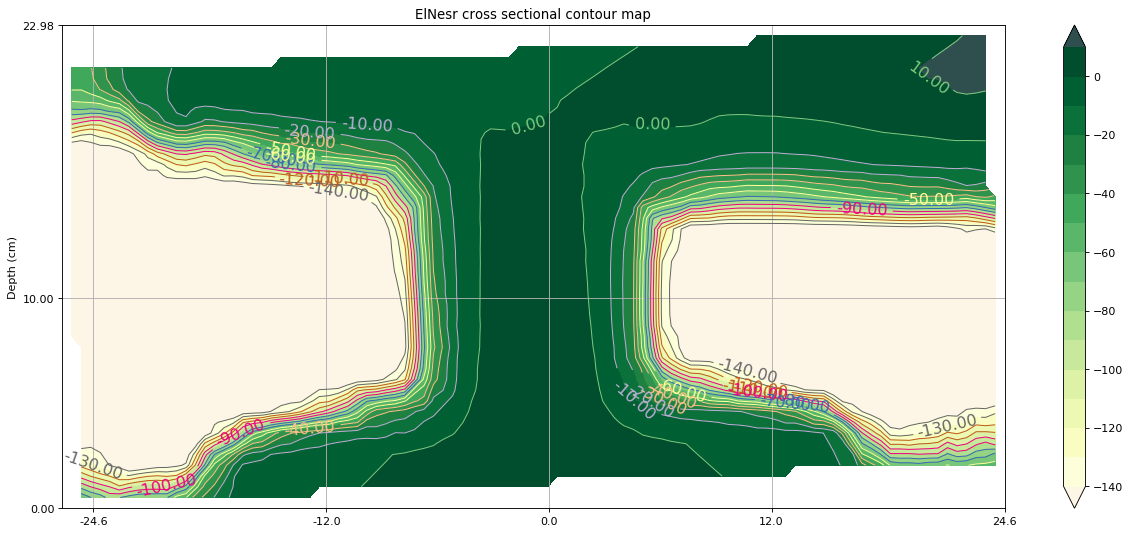

None

'V1'

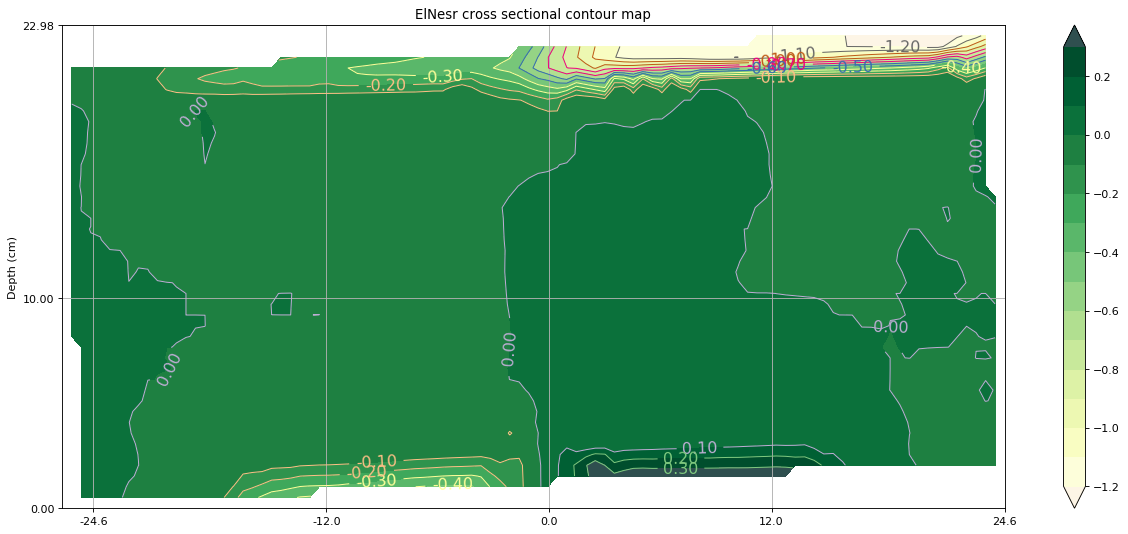

None

'V2'

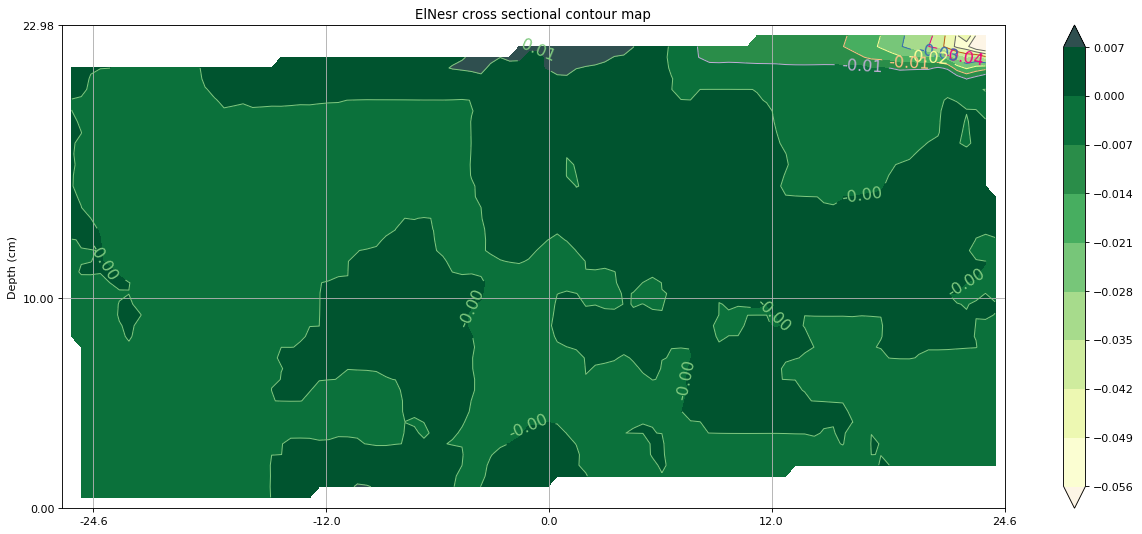

None

'V3'

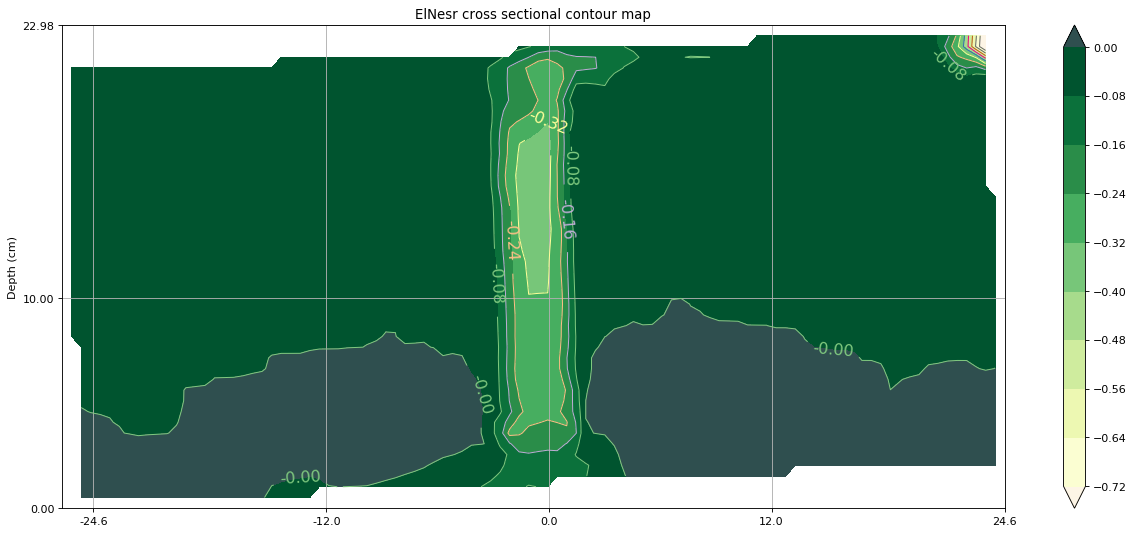

None

In [53]:
# testing draw_full_contour function
# variable = 2.3  # {Velocity z component}
time_step = 60
grid = 0.5  # cm
crosses = 15.  #cm0)]
tol = 10.
section = 'y'

for variable in [0, 1, 2.1, 2.2, 2.3]:
    display (v_mask[variable])
#     chart = draw_full_contour( df, variable, time_step, grid, crosses, tol,  
    draw_full_contour( df, variable, time_step, grid, crosses, tol,  
                          section, return_arrays=False, x_step=12, z_step=10, 
                          mirror_x=True, mirror_z=False, 
                          fig_size=get_fig_shape(df, section));
#     display(_)

'Th'

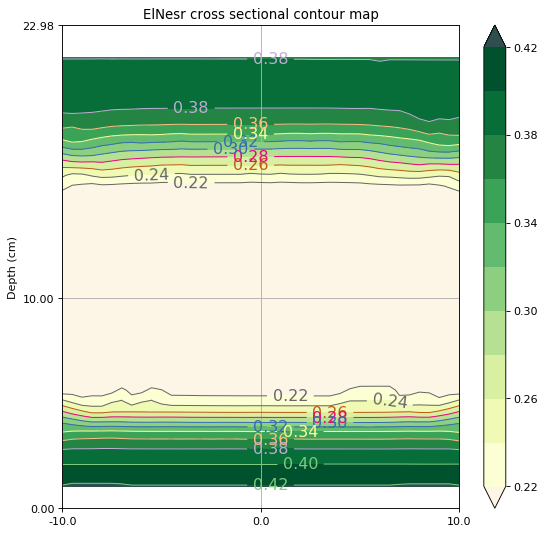

None

'H'

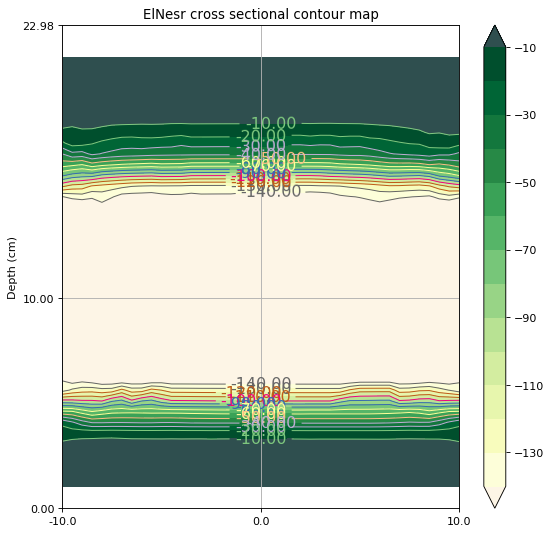

None

'V1'

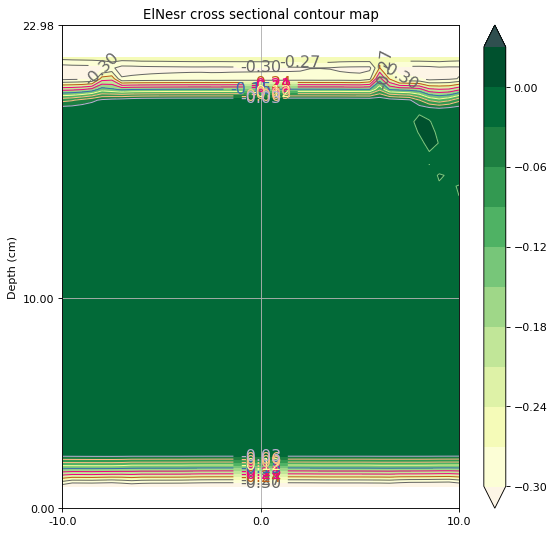

None

'V2'

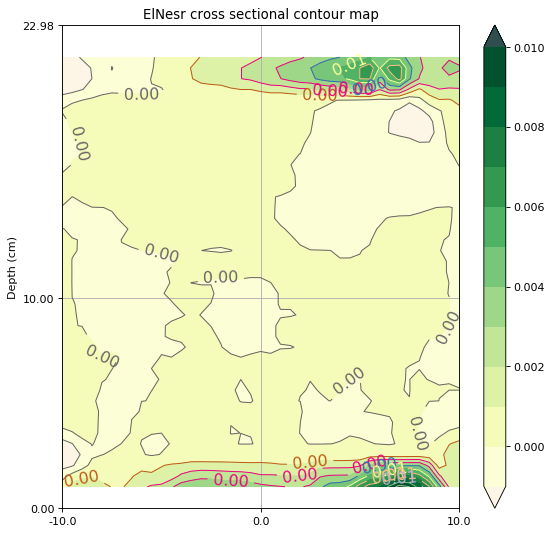

None

'V3'

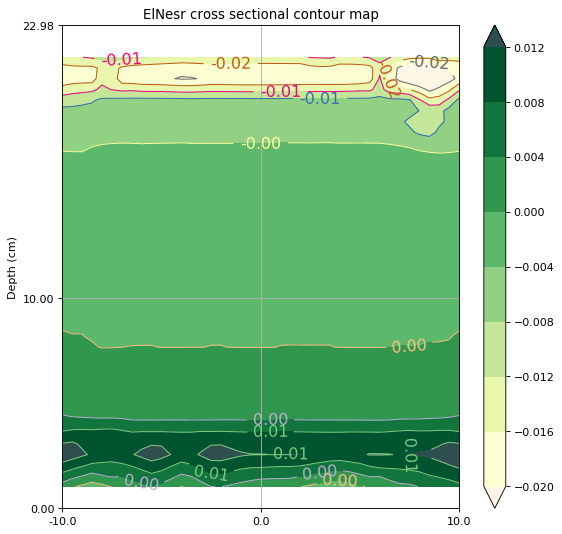

None

In [54]:
# testing draw_full_contour function
# variable = 2.3  # {Velocity z component}
time_step = 60
grid = 0.5  # cm
crosses = 15.  #cm0)]
tol = 10.
section = 'x'

for variable in [0, 1, 2.1, 2.2, 2.3]:
    display (v_mask[variable])
#     chart = draw_full_contour( df, variable, time_step, grid, crosses, tol,  
    draw_full_contour( df, variable, time_step, grid, crosses, tol,  
                          section, return_arrays=False, x_step=12, z_step=10, 
                          mirror_x=True, mirror_z=False, 
                          fig_size=get_fig_shape(df, section));
#     display(_)

'Th'

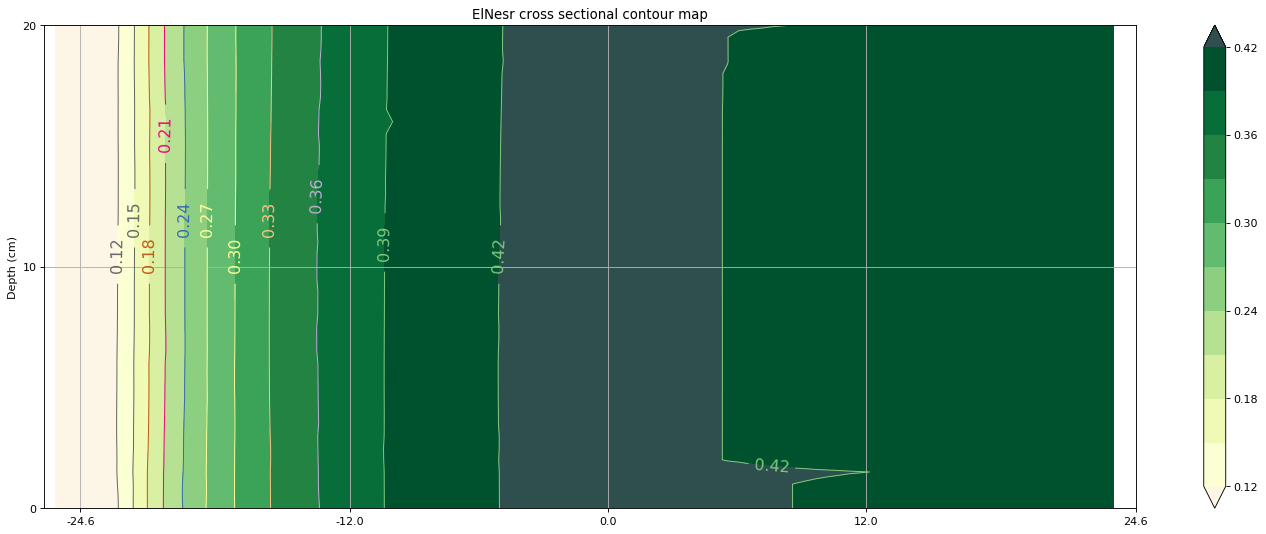

None

'H'

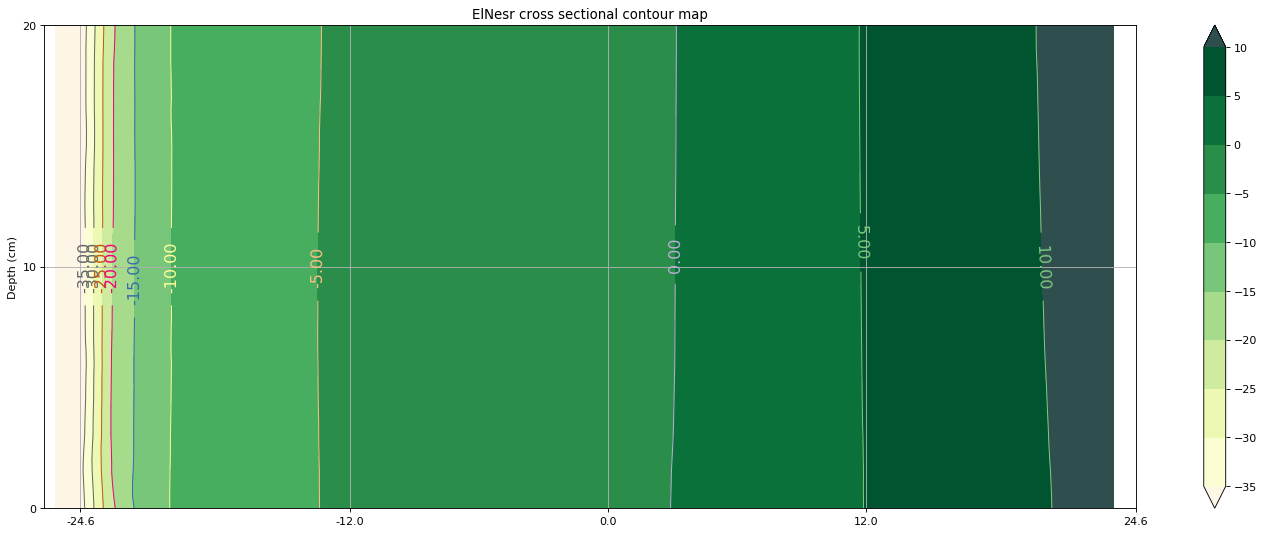

None

'V1'

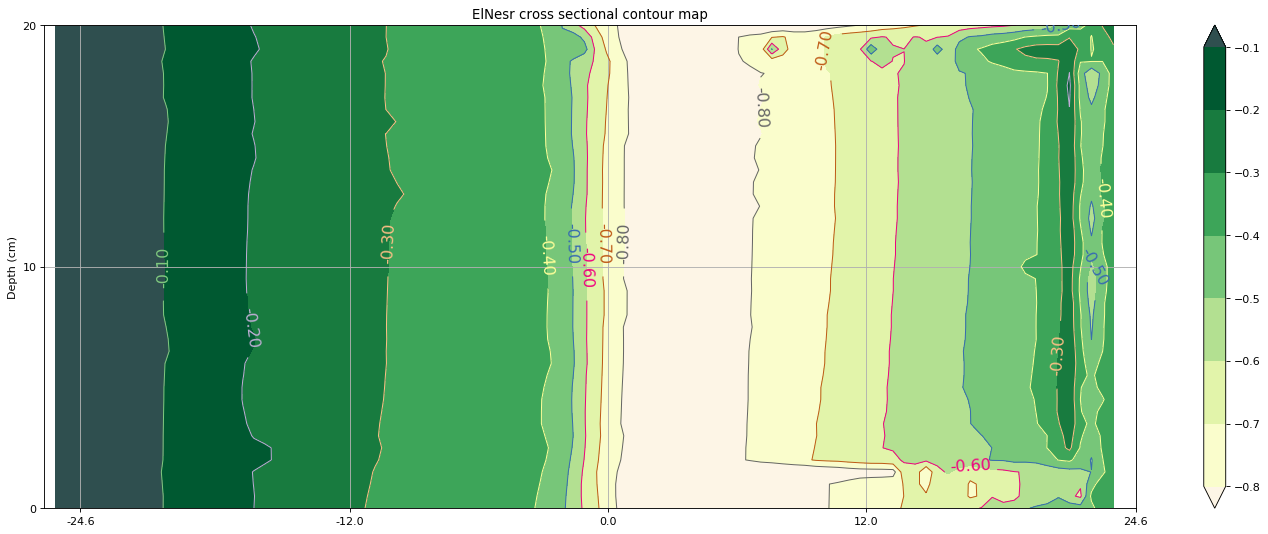

None

'V2'

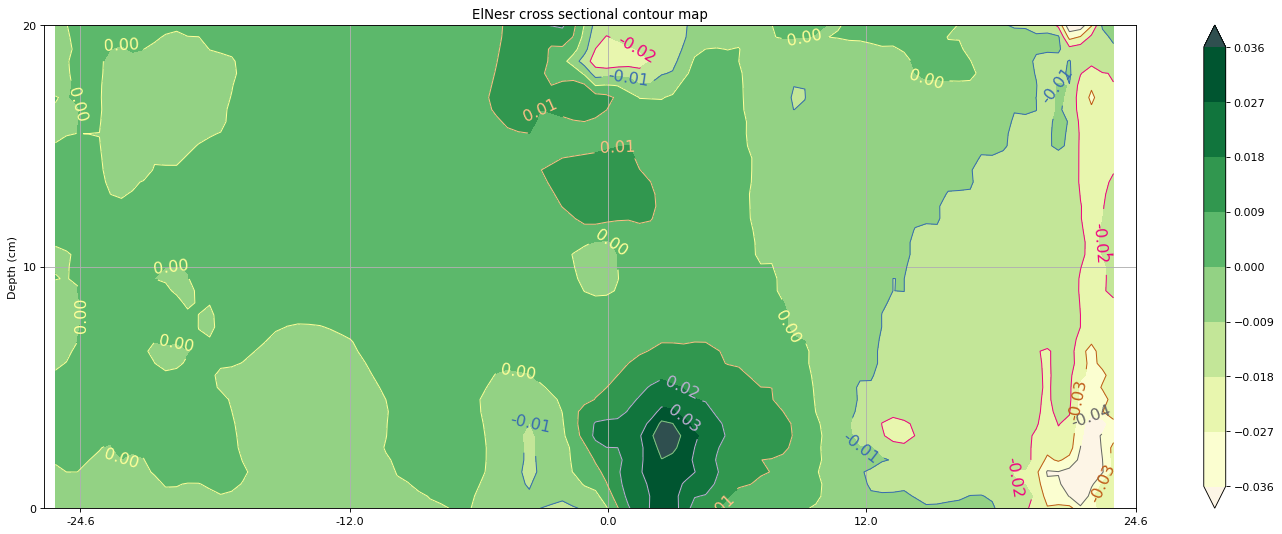

None

'V3'

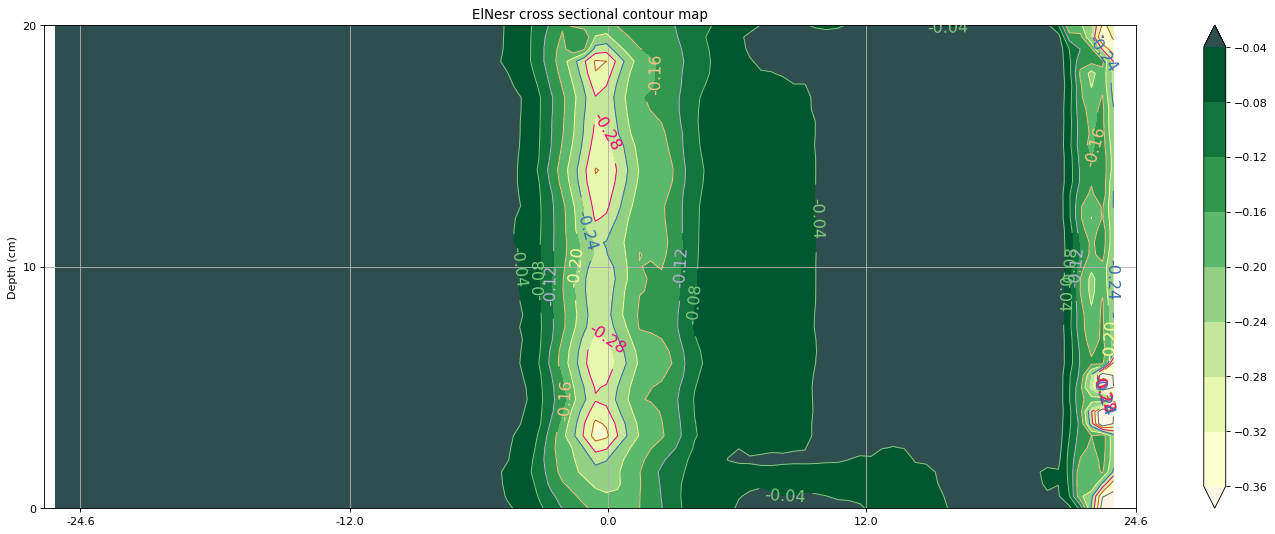

None

In [56]:
# testing draw_full_contour function
# variable = 2.3  # {Velocity z component}
time_step = 60
grid = 0.5  # cm
crosses = 21.  #cm0)]
tol = 10.
section = 'z'

for variable in [0, 1, 2.1, 2.2, 2.3]:
    display (v_mask[variable])
#     chart = draw_full_contour( df, variable, time_step, grid, crosses, tol,  
    draw_full_contour( df, variable, time_step, grid, crosses, tol,  
                          section, return_arrays=False, x_step=12, z_step=10, 
                          mirror_x=True, mirror_z=False, 
                          fig_size=get_fig_shape(df, section));
#     display(_)